In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# LOAD DATA
instructor_grades = pd.read_csv('./dataset/grades_instructors_all.tsv', sep='\t')
student_grades = pd.read_csv('./dataset/grades_students_all.tsv', sep='\t')
student_reports = pd.read_csv('./dataset/students_reports_mapping.tsv', sep='\t')

In [3]:
# CREATE STUDENT GRAPH

## get nodes from data
students = student_reports['student_id'].unique()
reports = student_reports['report_id'].unique()

## get edges from data
grades = [tuple([x[0], x[1], { 'grade': x[2] }]) for x in student_grades.values]

## create Graph
P = nx.Graph()
P.add_nodes_from(students, reputation=1/60, bipartite=0)
P.add_nodes_from(reports, quality=1, bipartite=1)
P.add_edges_from(grades)

/Users/joey/Development/peerAssessment/env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/joey/Development/peerAssessment/env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/joey/Development/peerAssessment/env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


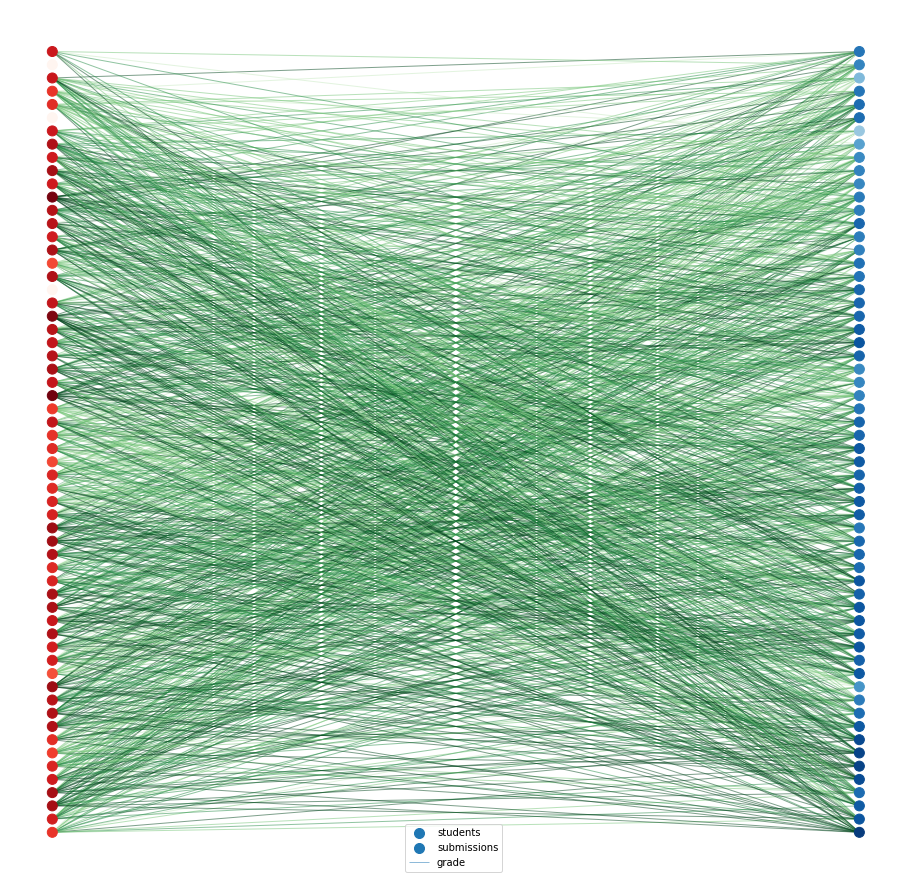

In [4]:
# CREATE STUDENT VISUALIZATION

## update node positions
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(students) )
pos.update( (n, (2, i)) for i, n in enumerate(reports) )
fig = plt.figure(1,figsize=(16,16))

## draw nodes
weights = [ 0 if x[1] == 0 else x[1] / P.degree(x[0]) for x in P.degree(students, weight='grade') ]
nx.draw_networkx_nodes(P, pos, nodelist=students.tolist(), node_color=weights, cmap=plt.cm.Reds, node_size=100, label='students', vmin=0, vmax=5)
weights = [ 0 if x[1] == 0 else x[1] / P.degree(x[0]) for x in P.degree(reports, weight='grade') ]
nx.draw_networkx_nodes(P, pos, nodelist=reports.tolist(), node_color=weights, cmap=plt.cm.Blues, node_size=100, label='submissions', vmin=0, vmax=5)

## draw edges
edges,weights = zip(*nx.get_edge_attributes(P,'grade').items())
nx.draw_networkx_edges(P, pos, edgelist=edges, edge_color=weights, alpha=0.5, label='grade', edge_cmap=plt.cm.Greens)

plt.axis('off')
plt.legend()
plt.savefig('figures/student_bipartite.png')
plt.show()

In [5]:
# CREATE INSTRUCTOR GRAPH

## get nodes from data
instructors = instructor_grades['instructor_id'].unique()
reports = instructor_grades['report_id'].unique()

## get edges from data
grades = [tuple([x[0], x[1], { 'grade': x[2] }]) for x in instructor_grades.values]

## create Graph
I = nx.Graph()
I.add_nodes_from(instructors, bipartite=0)
I.add_nodes_from(reports, bipartite=1)
I.add_edges_from(grades)

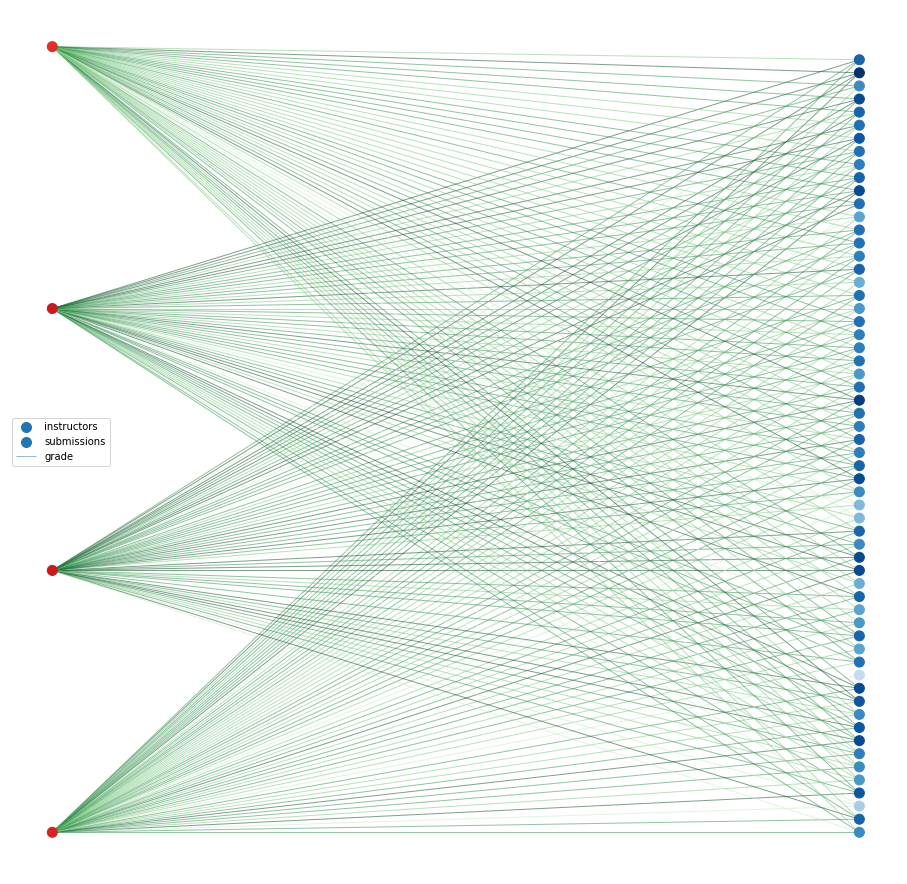

In [6]:
# CREATE INSTRUCTOR VISUALIZATION

## update node positions
pos = dict()
pos.update( (n, (1, i * len(reports)/(len(instructors)-1))) for i, n in enumerate(instructors) )
pos.update( (n, (2, i)) for i, n in enumerate(reports) )
plt.figure(1,figsize=(16,16))

## draw nodes
weights = [ 0 if x[1] == 0 else x[1] / I.degree(x[0]) for x in I.degree(instructors, weight='grade') ]
nx.draw_networkx_nodes(I, pos, nodelist=instructors.tolist(), node_color=weights, cmap=plt.cm.Reds,node_size=100, label='instructors', vmin=0, vmax=5)
weights = [ 0 if x[1] == 0 else x[1] / I.degree(x[0]) for x in I.degree(reports, weight='grade') ]
nx.draw_networkx_nodes(I, pos, nodelist=reports.tolist(), node_color=weights, cmap=plt.cm.Blues, node_size=100, label='submissions', vmin=0, vmax=5)

## draw edges
edges,weights = zip(*nx.get_edge_attributes(I,'grade').items())
nx.draw_networkx_edges(I, pos, edgelist=edges, edge_color=weights, alpha=0.5, label='grade', edge_cmap=plt.cm.Greens)

plt.axis('off')
plt.legend()
plt.savefig('figures/instructor_bipartite.png')
plt.show()

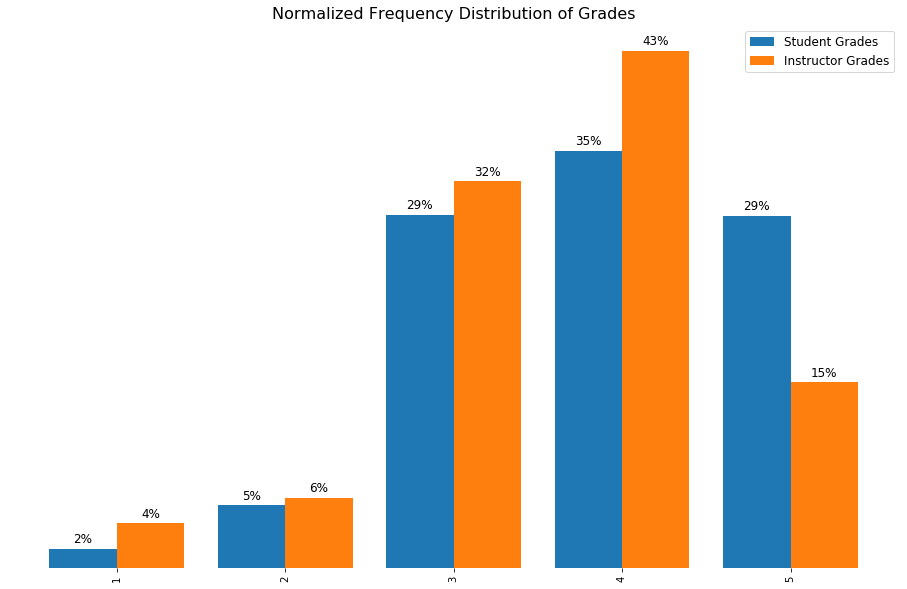

In [7]:
# Normalized Frequency Distribution of Grades
student_grade_freq = student_grades['grade'].value_counts() / student_grades.shape[0]
instructor_grade_freq = instructor_grades['grade'].value_counts() / instructor_grades.shape[0]

freq_dist_df = pd.DataFrame(data={ 'student_grades': student_grade_freq, 'instructor_grades': instructor_grade_freq}).sort_index()

ax = freq_dist_df.plot(kind='bar', width=0.8, figsize=(16,10))
ax.set_title('Normalized Frequency Distribution of Grades', fontsize=16)
ax.get_yaxis().set_ticks([])
ax.legend(['Student Grades', 'Instructor Grades'], fontsize=12)
for spine in ax.spines.values():
    spine.set_visible(False)
for p in ax.patches:
    ax.annotate(str(int(round(p.get_height() * 100))) + '%', (p.get_width()/2 + p.get_x(), p.get_height() + .005), ha='center', fontsize=12)

plt.savefig('figures/grade_frequency_dist.png')
plt.show()

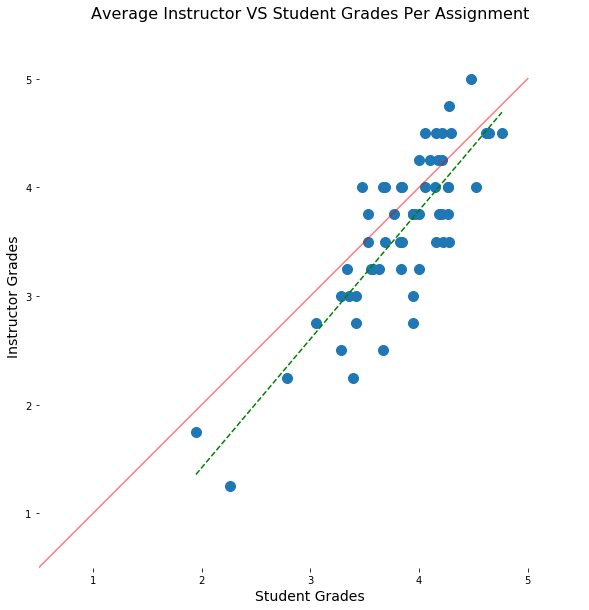

In [8]:
# Correlation Between Instructor and Student Grades
avg_student_grades = student_grades[['report_id', 'grade']].groupby('report_id').mean()
avg_instructor_grades = instructor_grades[['report_id', 'grade']].groupby('report_id').mean()
avg_grades_df = pd.DataFrame(data={
        'student_grades': avg_student_grades['grade'],
        'instructor_grades': avg_instructor_grades['grade']
    }).sort_values('student_grades')

ax = avg_grades_df.plot(kind='scatter', s=100, x='student_grades', y='instructor_grades',figsize=(10,10))
ax.set_title('Average Instructor VS Student Grades Per Assignment', fontsize=16)
ax.set_ylim((.5, 5.5))
ax.set_xlim((.5, 5.5))
ax.get_yaxis().set_ticks([1,2,3,4,5])
ax.get_xaxis().set_ticks([1,2,3,4,5])
ax.set_ylabel('Instructor Grades', fontsize=14)
ax.set_xlabel('Student Grades', fontsize=14)
plt.gca().set_aspect('equal', adjustable='box')
for spine in ax.spines.values():
    spine.set_visible(False)

x = np.linspace(0,5,100)
ax.plot(x, x, '-r', alpha=0.5)

x = avg_grades_df['student_grades']
y = avg_grades_df['instructor_grades']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x , p(x),"g--")

plt.savefig('figures/mean_grade_correlation.png')
plt.show()

**Definitions:**

$U$ - The set of student graders

$O$ - The set of reports

$i$ - Individual student grader

$\chi$ - Individual report

$r_{i\chi}$ - the rating given by student $i$ to report $\chi$

$U_\chi$ - Set of users that reviewed report $\chi$

$O_i$ - Set of reports reviewed by student $i$

$k_i$ - Degree of users

$k_\chi$ - Degree of report

$R_i$ - Reputation of student $i$

$TR_i$ - Temporal reputation of student $i$

$Q_\chi$ - Quality of report

$M$ - number of reports

In [9]:
# Initialize Working Student Graph
students = student_reports['student_id'].unique()
reports = student_reports['report_id'].unique()
grades = [tuple([x[0], x[1], { 'grade': x[2] }]) for x in student_grades.values]

B = nx.Graph()
B.add_nodes_from(students, reputation=0, bipartite=0)
B.add_nodes_from(reports, quality=0, bipartite=1)
B.add_edges_from(grades)

## initialize reputations
for student_id in students:
    init_reputation = B.degree(student_id) / len(reports)
    nx.set_node_attributes(B, {student_id: init_reputation}, 'reputation')

In [10]:
# Initialize parameters
theta = 2

In [11]:
# Iterate Time Steps
for i in range(100):
    
    # update quality of reports
    for report_id in reports:
        grades, reputations = list(zip(*[(grade, B.nodes[v]['reputation']) for u,v,grade in B.edges(report_id, data='grade')]))
        quality = np.average(grades, weights=reputations)
        nx.set_node_attributes(B, {report_id: quality}, 'quality')
        
    # calculate temporal reputation
    TR = []
    for student_id in students:
        if (B.degree(student_id) > 0):
            grades, qualities = list(zip(*[(grade, B.nodes[v]['quality']) for u,v,grade in B.edges(student_id, data='grade')]))
            tr = np.corrcoef(grades, qualities)[0][1]
            TR.append(tr if tr > 0 else 0)
        else:
            TR.append(0)
    
    # redistribute temporal reputation
    R = np.power(TR, theta) * np.sum(TR) / np.sum(np.power(TR, theta))
    for i, student_id in enumerate(students):
        nx.set_node_attributes(B, {student_id: R[i]}, 'reputation')
    

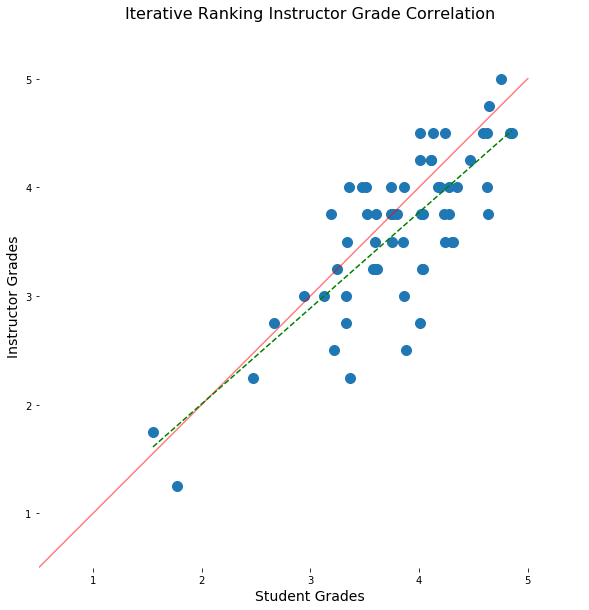

In [12]:
# Correlation Between Instructor and Student Grades
avg_student_grades = pd.DataFrame([(x, y['quality']) for x,y in B.nodes(data=True) if 'quality' in y], columns=['report_id', 'grade'])
avg_student_grades = avg_student_grades.set_index('report_id')
avg_instructor_grades = instructor_grades[['report_id', 'grade']].groupby('report_id').mean()
avg_grades_df = pd.DataFrame(data={
        'student_grades': avg_student_grades['grade'],
        'instructor_grades': avg_instructor_grades['grade']
    }).sort_values('student_grades')

ax = avg_grades_df.plot(kind='scatter', s=100, x='student_grades', y='instructor_grades',figsize=(10,10))
ax.set_title('Iterative Ranking Instructor Grade Correlation', fontsize=16)
ax.set_ylim((.5, 5.5))
ax.set_xlim((.5, 5.5))
ax.get_yaxis().set_ticks([1,2,3,4,5])
ax.get_xaxis().set_ticks([1,2,3,4,5])
ax.set_ylabel('Instructor Grades', fontsize=14)
ax.set_xlabel('Student Grades', fontsize=14)
plt.gca().set_aspect('equal', adjustable='box')
for spine in ax.spines.values():
    spine.set_visible(False)

x = np.linspace(0,5,100)
ax.plot(x, x, '-r', alpha=0.5)

x = avg_grades_df['student_grades']
y = avg_grades_df['instructor_grades']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x , p(x),"g--")

plt.savefig('figures/ir_grade_correlation.png')
plt.show()